## Энергетический оракул
Ноутбук команды #12

Работа выполнена на основе модели LightGBM


### 1. Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random

import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import re

from tqdm import tqdm
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True )


random_state = 12345
NUM_ITERATIONS = 5000

FEATURES = 'base feature'

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


#### 1.1 Функции для расшифровки прогноза погоды в колонке 'weather_pred'

In [2]:
# Расшифровка прогноза в колонке 'weather_pred'

# функция формирует колонки 'cloudy', 'rainy', 'windy', 'clear', 'rain_probability', 'has_rain_probability'
# в колонках число, которое 0 при отсутсвии упоминания явления в weather_pred или степень упоминания
# функция дает в колонках номер первого списка, элемент которого есть в строке плюс 1
# списки cloudy_list, rainy_list, windy_list, clear_list можно модифицировать
# соответственно, можно экспериментировать с расположением значений в списках
# например, сейчас 'дождь', 'снег', 'д+сн' - первая степень  дождя, а 'гроз', 'ливень' - вторая
# а можно сделать снег второй, а грозу с ливнем убрать в третью
# также сделал отдельный список для "ясности", чтобы выделить 'ясно' и 'солнечно'

def in_what_list(weather, big_list):
    for list_number, small_list in enumerate(big_list):
        if any(word in weather for word in small_list):
            return list_number+1
    return 0

def weather_split2(row):
    weather = row['weather_pred']
    cloudy_list = [['проясн', 'пер.об.', 'п/об'], ['пасм', 'обл']]
    rainy_list = [['дождь', 'снег', 'д+сн'], ['гроз', 'ливень']]
    windy_list = [['вет'],['штор']]
    clear_list = [['проясн'], ['ясно'], ['солнеч']]
    numbers = re.findall(r'\d+', weather)
    cloudy = in_what_list(weather, cloudy_list)
    rainy = in_what_list(weather, rainy_list)
    windy = in_what_list(weather, windy_list)
    clear = in_what_list(weather, clear_list)
    rain_probability = 0 if len(numbers)==0 else int(numbers[0])
    has_rain_probability = int(len(numbers)==0)
    return cloudy, rainy, windy, clear, rain_probability, has_rain_probability

def fill_weather_columns(df):
    df['weather_pred'] = df['weather_pred'].fillna('')
    df['cloudy'], df['rainy'], df['windy'], df['clear'], df['rain_probability'], df['has_rain_probability'] = \
                zip(*df.apply(weather_split2, axis=1))
    return df

#### 1.2 Функции для загрузки данных о ВВП 
данные загружаются из файла 'data/VVP.csv'

Некоторые научные работы указывают на прямую связь величины потребления электричества и показателя ВВП, который отражает ситуацию в экономике. Данные по экономике публикуются различными министерствами с разной периодичностью. Для использования в работе были взяты фактические данные по ВВП с сайта investing, который агрегирует публикации Минэкономразвития. Данные за месяц побликуются с месячной задержкой, поэтому модель использует для прогнозирования данные за прошлые месяцы, которые известны.   
  
Ссылка на данные: https://ru.investing.com/economic-calendar/russian-monthly-gdp-407


In [3]:
# Функция добавляет данные о ВВП из файла 'data/VVP.csv' в датасет

def add_vvp2(data, file_source = 'data/VVP.csv'):
    """
    сырой датафрем подаем на вход
    """
    # обработаем файл с динамикой ВВП
    vvp = pd.read_csv(file_source)
    # преобразуем дату файла-источника в формат datetime64 и дропнем один столбик
    vvp['date'] = pd.to_datetime(vvp['date'], format ='%Y-%m-%d %H:%M:%S')
    vvp.drop('for_month',axis=1,inplace=True) 
    
    # обработаем основной фрейм - создадим столбец для соединения, который потом удалим
    data['date_temp'] = pd.to_datetime(data['date'], format = '%Y-%m-%d' )
    data['date_temp'] = data['date_temp'] + pd.to_timedelta(data['time'] , 'H')
    
    # соединяем основной фрейм и ВВП по дате объявления показтеля ВВП
    for idx in reversed(vvp.index):
        data.loc[data['date_temp']>=vvp.date[idx],'VVP'] = vvp.VVP_perc[idx]
        
    data.drop('date_temp',axis=1,inplace=True)   

    return data

#### 1.3 Функции для загрузки архива данных о фактической погоде
данные загружаются из файла 'data/preprocessing_loaded_table.csv'

Изначально данные для формирования таблицы "preprocessing_loaded_table" были взяты из с сайта [https://rp5.ru](https://rp5.ru/Архив_погоды_в_Храброво,_им._императрицы_Елизаветы_Петровны_(аэропорт),_METAR), где хранятся архивы погоды в аэрапорту Калининграда, за период с 31.12.2018 по 30.09.2023

Описание данных в таблице:
- Местное время в Храброво / им. императрицы Елизаветы Петровны (аэропорт) - Дата / Местное время
- T -  Темпиратура воздуха
- Po - Давление на уровне станции
- P - Давление приведённое к уровню моря
- U - Относительная влажность
- DD - Направление ветра
- Ff - Скорость ветра
- ff10 - Максимальное значение порыва ветра
- WW - Особое явление текущей погоды (осадки)
- W'W' - Явление недавней погоды, имеющее оперативное значение
- с - Общая облачность
- VV - Горизонтальная дальность видимости
- Td - Темпиратура точки росы

Данные, которые были взяты из данной таблицы и загружаются из 'data/preprocessing_loaded_table.csv':
- P - не подверглось изменению
- U - не подверглось изменению
- Td - не подверглась изменению

 WW - разделили на 4 категории:
- Нет осадков (где были пропуски)
- слабый дождь
- сильный дождь
- снег

DD - создали 4 столбца, соответствующих сторонам горизонта, которые принимали значения 0; 0.5 и 1 в зависимости от силы ветра в конкретном направлении
- N - north
- S - south
- W - west
- E - east

В дальнейшем эти данные использовались с лагом в сутки: в поля на завтрашний день записывались данные сегодняшнего.

In [4]:
# Функции для работы с данными о фактической погоде из 'data/preprocessing_loaded_table.csv'

# Кодировка информации об осадках из колонки WW
def true_weather_WW_replace(ww):
    if ww=='нет осадков':
        return 0
    elif ww=='слабый дождь':
        return 1
    elif (ww=='сильный дождь') or (ww=='снег'):
        return 2
    else:
        return 3

# Вычисление Timestamp из даты и времени
def row_plus_hours_to_index(row):
    return row['date'] + pd.to_timedelta(row['time'] , 'H')

# Функция для сдвига на сутки (в скачанном датасете разбивка по 30 мин, поэтому timeshift=48)
def shift_features_fact(df, timeshift=48):
    list_fact_columns=list(df.columns)
    list_fact_columns.remove('date_tw')
    new_df = df.copy()
    for column in list_fact_columns:
        new_df[column] = new_df[column].shift(timeshift)

    return new_df

In [5]:
# Функция для вычисления метрики mae по дням из почасовых массивов данных

def mae_day(y_true, y_pred):
    y_true_copy = pd.DataFrame(y_true).reset_index(drop=True)
    y_true_copy['day'] = y_true_copy.index // 24
    y_true_grouped = y_true_copy.groupby(by='day').sum()   
    y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
    y_pred_copy['day'] = y_pred_copy.index // 24
    y_pred_grouped = y_pred_copy.groupby(by='day').sum()
    
    return mean_absolute_error(y_true_grouped, y_pred_grouped)
# Функция для вычисления метрик по дням из почасовых массивов данных

def metrics_hour(y_true, y_pred):

    
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mape, r2

#### 1.5 Чтение файлов с данными
Данные объединяются в один датасет

In [6]:
# читаем исходные датасеты и складываем в один
train_ds = pd.read_csv('data/train_dataset.csv')
test_ds = pd.read_csv('data/test_dataset.csv')
train_ds = pd.concat([train_ds, test_ds])

# запоминаем дату начала тестовых данных, потом также поступим и с закрытым датасетом
open_test_begin = pd.to_datetime(test_ds['date']).min()
open_test_end = pd.to_datetime(test_ds['date']).max() + pd.to_timedelta(1,'d')
print('начало открытого теста:', open_test_begin, '    конец открытого теста:', open_test_end)

начало открытого теста: 2023-04-01 00:00:00     конец открытого теста: 2023-08-01 00:00:00


#### 1.6 Формирование колонок с производными от даты

In [7]:
# преобразуем дату и делаем из нее колонки
train_ds['date'] = pd.to_datetime(train_ds['date'])
train_ds['year'] = train_ds['date'].dt.year
train_ds['month'] = train_ds['date'].dt.month
train_ds['day_of_week'] = train_ds['date'].dt.dayofweek
train_ds['day'] = train_ds['date'].dt.day
train_ds['day_of_year'] = train_ds['date'].dt.dayofyear

In [8]:
train_ds.sample(5)

,date,time,target,temp,temp_pred,weather_pred,weather_fact,year,month,day_of_week,day,day_of_year
15645,2020-10-13,21,537.193,9.8,8.0,"пасм, 59%","пасмурно, ветер",2020,10,1,13,287
7463,2019-11-07,23,509.494,5.1,4.0,обл с проясн,туман,2019,11,3,7,311
25738,2021-12-08,10,734.292,-11.0,-10.0,"ясно, ветер",пасмурно,2021,12,2,8,342
13914,2020-08-02,18,404.067,22.0,20.0,обл с пр,п/обл,2020,8,6,2,215
29545,2022-05-16,1,377.222,5.1,5.0,ясно,ясно,2022,5,0,16,136


#### 1.7 Подгрузка Auggumentaci в праздниках


df_holidays = pd.read_csv('data/holidays_aug.csv')
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
# Добавление данных о праздниках из файла 'data/holidays.csv'


print('размер DS', train_ds.shape, 'дубликатов - ', train_ds.duplicated().sum())
# Assuming df_holidays and train_ds are your dataframes
train_ds = pd.merge(train_ds, df_holidays, on='date', how='left')
print('размер DS', train_ds.shape, 'дубликатов - ', train_ds.duplicated().sum())
# Fill NaN values with 0
train_ds['holidays'].fillna(0, inplace=True)
train_ds['preholidays'].fillna(0, inplace=True)

# Convert to int
train_ds['holidays'] = train_ds['holidays'].astype(int)
train_ds['preholidays'] = train_ds['preholidays'].astype(int)
print('размер DS', train_ds.shape, 'дубликатов - ', train_ds.duplicated().sum())

#### 1.7.1 Подгрузка данных о праздниках на весь DS праздниках

In [9]:

df_holidays_true = pd.read_csv('data/holidays_true.csv')
df_holidays_true['date'] = pd.to_datetime(df_holidays_true['date'])
# Добавление данных о праздниках из файла 'data/holidays.csv'
print('размер DS', train_ds.shape, 'дубликатов - ', train_ds.duplicated().sum())
# Assuming df_holidays and train_ds are your dataframes
train_ds = pd.merge(train_ds, df_holidays_true, on='date', how='left')

# Fill NaN values with 0
train_ds['holidays_true'].fillna(0, inplace=True)
train_ds['preholidays_true'].fillna(0, inplace=True)

# Convert to int
train_ds['holidays_true'] = train_ds['holidays_true'].astype(int)
train_ds['preholidays_true'] = train_ds['preholidays_true'].astype(int)
print('размер DS', train_ds.shape, 'дубликатов - ', train_ds.duplicated().sum())

размер DS (40152, 12) дубликатов -  0
размер DS (40152, 14) дубликатов -  0


In [10]:
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40152 entries, 0 to 40151
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              40152 non-null  datetime64[ns]
 1   time              40152 non-null  int64         
 2   target            40152 non-null  float64       
 3   temp              40152 non-null  float64       
 4   temp_pred         40040 non-null  float64       
 5   weather_pred      40040 non-null  object        
 6   weather_fact      40151 non-null  object        
 7   year              40152 non-null  int32         
 8   month             40152 non-null  int32         
 9   day_of_week       40152 non-null  int32         
 10  day               40152 non-null  int32         
 11  day_of_year       40152 non-null  int32         
 12  holidays_true     40152 non-null  int64         
 13  preholidays_true  40152 non-null  int64         
dtypes: datetime64[ns](1), 

#### 1.8 Формирование колонок со значением целевого признака в предыдущие дни

In [11]:
# Добавление колонок с временными лагами

# создаем столбец 'temp_last_day'
train_ds['temp_last_day'] = train_ds['temp'].shift(24)
print('размер DS', train_ds.shape, 'дубликатов - ', train_ds.duplicated().sum())
# заполняем пропущенные значения в 'temp_last_day'
train_ds['temp_last_day'].fillna(method='bfill', inplace=True)

# создаем столбцы с временными лагами для 'target'
lags = [24, 48, 72, 7*24, 14*24]
for lag in lags:
    train_ds[f'target_lag_{lag}'] = train_ds['target'].shift(lag)

# заполняем пропущенные значения в столбцах с лагами
for lag in lags:
    train_ds[f'target_lag_{lag}'].fillna(0, inplace=True)

print('размер DS', train_ds.shape, 'дубликатов - ', train_ds.duplicated().sum())

размер DS (40152, 15) дубликатов -  0
размер DS (40152, 20) дубликатов -  0


/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_35111/2320664940.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_ds['temp_last_day'].fillna(method='bfill', inplace=True)


#### 1.9 Формирование колонок с ВВП и данными о погоде посредством ранее описанных функций

In [12]:
# применяем функцию добавления ВВП
train_ds = add_vvp2(train_ds)

# Расшифровка прогноза в колонке 'weather_pred'
train_ds = fill_weather_columns(train_ds)


# Читаем файл с архивом фактической погоды
df_true_weather = pd.read_csv('data/preprocessing_loaded_table.csv')
display(df_true_weather)

# Форматируем колонки
df_true_weather['WW'] = df_true_weather['WW'].apply(true_weather_WW_replace)
df_true_weather['date'] = pd.to_datetime(df_true_weather['date'])
df_true_weather = df_true_weather.rename(columns={'date':'date_tw'})
# Применяем сдвиг на сутки, чтобы не заглядывать в будущее
df_true_weather = shift_features_fact(df_true_weather)
# Добавляем в датасет
train_ds['date_hours'] = train_ds.apply(row_plus_hours_to_index, axis=1)
train_ds = train_ds.merge(df_true_weather, left_on='date_hours', right_on='date_tw')
train_ds = train_ds.drop(['date_hours', 'date_tw'], axis=1)

,date,P,U,WW,Td,N,S,W,E
0,2018-12-31 00:00:00,763.5,100.0,слабый дождь,2.0,1.0,0.0,0.0,0.0
1,2018-12-31 00:30:00,764.3,93.0,слабый дождь,1.0,1.0,0.0,0.0,0.5
2,2018-12-31 01:00:00,764.3,93.0,слабый дождь,1.0,1.0,0.0,0.0,0.0
3,2018-12-31 01:30:00,765.0,93.0,слабый дождь,2.0,1.0,0.0,0.0,0.0
4,2018-12-31 02:00:00,765.0,93.0,нет осадков,2.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
82146,2023-09-30 21:30:00,763.5,82.0,нет осадков,12.0,0.0,0.0,1.0,0.0
82147,2023-09-30 22:00:00,763.5,82.0,нет осадков,12.0,0.5,0.0,1.0,0.0
82148,2023-09-30 22:30:00,763.5,77.0,сильный дождь,11.0,0.0,0.0,1.0,0.0
82149,2023-09-30 23:00:00,763.5,94.0,сильный дождь,13.0,0.5,0.0,1.0,0.0


###  Новые фичи

from add_new_data import (add_euro,
                            add_light_work,
                            add_stock,
                            add_ipp_mm,
                            add_ipp_yy,)

#### 1.9.1 Euro

FEATURES = 'add_euro'
train_ds = add_euro(train_ds)



#### 1.9.2 Stock

FEATURES = 'add_stock'
train_ds = add_stock(train_ds)



#### 1.9.3 IPP Month

FEATURES = 'add_ipp_mm'
train_ds = add_ipp_mm(train_ds)



#### 1.9.4 IPP Year

FEATURES = 'add_ipp_yy'
train_ds = add_ipp_yy(train_ds)



#### 1.9.5 Light work

FEATURES = 'add_light_work'
train_ds = add_light_work(train_ds)



#### 1.9.6 All

FEATURES = 'add_all'

train_ds = add_euro(train_ds)
train_ds = add_stock(train_ds)
train_ds = add_ipp_mm(train_ds)
train_ds = add_ipp_yy(train_ds)
train_ds = add_light_work(train_ds)



#### 1.10 Демонстрация сформированного датасета

In [13]:
# Итоговый набор колонок
train_ds.columns

Index(['date', 'time', 'target', 'temp', 'temp_pred', 'weather_pred',
       'weather_fact', 'year', 'month', 'day_of_week', 'day', 'day_of_year',
       'holidays_true', 'preholidays_true', 'temp_last_day', 'target_lag_24',
       'target_lag_48', 'target_lag_72', 'target_lag_168', 'target_lag_336',
       'VVP', 'cloudy', 'rainy', 'windy', 'clear', 'rain_probability',
       'has_rain_probability', 'P', 'U', 'WW', 'Td', 'N', 'S', 'W', 'E'],
      dtype='object')

In [14]:
train_ds.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact,year,month,day_of_week,...,rain_probability,has_rain_probability,P,U,WW,Td,N,S,W,E
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,1,763.5,100.0,1.0,2.0,1.0,0.0,0.0,0.0
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,1,764.3,93.0,1.0,1.0,1.0,0.0,0.0,0.0
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,1,765.0,93.0,0.0,2.0,1.0,0.0,0.0,0.0
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,0,1,765.8,87.0,0.0,1.0,1.0,0.0,0.0,0.0
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,0,1,766.6,87.0,0.0,1.0,1.0,0.0,0.0,0.0


#### 1.11.1 Добавление среднего за час предыдущего дня

In [15]:

def mean_evening(values, evening=19):
    return values[evening:].mean()

evening_slices = [0, 19, 22]
    
for evening_slice in evening_slices:
    train_ds[['last_evening_avg_target_'+str(evening_slice), 'last_evening_avg_temp_'+str(evening_slice)]] = \
        train_ds[['date', 'target', 'temp']].groupby(by='date').transform(mean_evening, evening=evening_slice).shift(24)

In [16]:
train_ds.columns

Index(['date', 'time', 'target', 'temp', 'temp_pred', 'weather_pred',
       'weather_fact', 'year', 'month', 'day_of_week', 'day', 'day_of_year',
       'holidays_true', 'preholidays_true', 'temp_last_day', 'target_lag_24',
       'target_lag_48', 'target_lag_72', 'target_lag_168', 'target_lag_336',
       'VVP', 'cloudy', 'rainy', 'windy', 'clear', 'rain_probability',
       'has_rain_probability', 'P', 'U', 'WW', 'Td', 'N', 'S', 'W', 'E',
       'last_evening_avg_target_0', 'last_evening_avg_temp_0',
       'last_evening_avg_target_19', 'last_evening_avg_temp_19',
       'last_evening_avg_target_22', 'last_evening_avg_temp_22'],
      dtype='object')

#### 1.11 Исключение лишних колонок

In [17]:
# Отбираем признаки. Все лишние колонки здесь отбрасываем, кроме 'date', которую уберем позже 

feature_cols = list(train_ds.columns)

# выбрасываем взгляд в прошлое и расшифрованную погоду
drop_list = ['target', 'day_of_year', 'weather_pred', 'weather_fact', 'temp']

# выбрасываем признаки, найденные процедурно в процессе оптимизации
# КОМАНДЕ: здесь можно добавлять признаки на выброс с целью оптимизации
drop_list = drop_list + ['target_lag_48', 'target_lag_168'] #, 'temp_pred'] #, 'target_lag_336'] 

for name in drop_list:
    feature_cols.remove(name)

# Итоговый список признаков
feature_cols

['date',
 'time',
 'temp_pred',
 'year',
 'month',
 'day_of_week',
 'day',
 'holidays_true',
 'preholidays_true',
 'temp_last_day',
 'target_lag_24',
 'target_lag_72',
 'target_lag_336',
 'VVP',
 'cloudy',
 'rainy',
 'windy',
 'clear',
 'rain_probability',
 'has_rain_probability',
 'P',
 'U',
 'WW',
 'Td',
 'N',
 'S',
 'W',
 'E',
 'last_evening_avg_target_0',
 'last_evening_avg_temp_0',
 'last_evening_avg_target_19',
 'last_evening_avg_temp_19',
 'last_evening_avg_target_22',
 'last_evening_avg_temp_22']

#### 1.11.2 Добавление среднего за час предыдущего дня

In [18]:
FEATURE_WINDOW_SIZE = 24
feature_cols_no_date = feature_cols.copy()
feature_cols_no_date.remove('date')


for lag in range(1,FEATURE_WINDOW_SIZE):
    for column in feature_cols_no_date:
        train_ds[column+'_'+str(lag)] = train_ds[column].shift(lag)

/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_35111/4047160460.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_ds[column+'_'+str(lag)] = train_ds[column].shift(lag)
/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_35111/4047160460.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_ds[column+'_'+str(lag)] = train_ds[column].shift(lag)
/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_35111/4047160460.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

#### 1.11.2 Добавление лагов за час 

In [19]:
target_lags=[1, 5, 9]

for lag in target_lags:
    train_ds['target_'+str(lag)] = train_ds['target'].shift(lag).where(train_ds['time']<lag, np.NaN)
    train_ds['temp_'+str(lag)] = train_ds['temp'].shift(lag).where(train_ds['time']<lag, np.NaN)

/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_35111/64960772.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_ds['target_'+str(lag)] = train_ds['target'].shift(lag).where(train_ds['time']<lag, np.NaN)
/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_35111/64960772.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_ds['temp_'+str(lag)] = train_ds['temp'].shift(lag).where(train_ds['time']<lag, np.NaN)
/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_35111/64960772.py:4: PerformanceW

In [20]:
feature_cols = list(train_ds.columns)
for name in drop_list:
    feature_cols.remove(name)

# Итоговый список признаков
feature_cols

['date',
 'time',
 'temp_pred',
 'year',
 'month',
 'day_of_week',
 'day',
 'holidays_true',
 'preholidays_true',
 'temp_last_day',
 'target_lag_24',
 'target_lag_72',
 'target_lag_336',
 'VVP',
 'cloudy',
 'rainy',
 'windy',
 'clear',
 'rain_probability',
 'has_rain_probability',
 'P',
 'U',
 'WW',
 'Td',
 'N',
 'S',
 'W',
 'E',
 'last_evening_avg_target_0',
 'last_evening_avg_temp_0',
 'last_evening_avg_target_19',
 'last_evening_avg_temp_19',
 'last_evening_avg_target_22',
 'last_evening_avg_temp_22',
 'time_1',
 'temp_pred_1',
 'year_1',
 'month_1',
 'day_of_week_1',
 'day_1',
 'holidays_true_1',
 'preholidays_true_1',
 'temp_last_day_1',
 'target_lag_24_1',
 'target_lag_72_1',
 'target_lag_336_1',
 'VVP_1',
 'cloudy_1',
 'rainy_1',
 'windy_1',
 'clear_1',
 'rain_probability_1',
 'has_rain_probability_1',
 'P_1',
 'U_1',
 'WW_1',
 'Td_1',
 'N_1',
 'S_1',
 'W_1',
 'E_1',
 'last_evening_avg_target_0_1',
 'last_evening_avg_temp_0_1',
 'last_evening_avg_target_19_1',
 'last_evening_avg

#### 1.11.13 Аугументации

In [21]:
feature_target = feature_cols +['target']
#feature_target.remove('date')
print(feature_target)
feature_aug = [ 'temp_pred', 'temp_last_day', 'target_lag_24', 'target_lag_72', 
                'target_lag_336', 'VVP', 'P', 'U', 'Td', 'target', 
                'last_evening_avg_target_0',
                'last_evening_avg_temp_0',
                'last_evening_avg_target_19',
                'last_evening_avg_temp_19',
                'last_evening_avg_target_22',
                'last_evening_avg_temp_22',
                'last_evening_avg_target_0_1', 'last_evening_avg_temp_0_1',
                'last_evening_avg_target_19_1', 'last_evening_avg_temp_19_1',
                'last_evening_avg_target_22_1', 'last_evening_avg_temp_22_1',
                'temp_last_day_1',
                'target_lag_24_1',
                'target_lag_72_1',
                'target_lag_336_1','VVP_1']

train_ds[feature_aug].sample(20)

['date', 'time', 'temp_pred', 'year', 'month', 'day_of_week', 'day', 'holidays_true', 'preholidays_true', 'temp_last_day', 'target_lag_24', 'target_lag_72', 'target_lag_336', 'VVP', 'cloudy', 'rainy', 'windy', 'clear', 'rain_probability', 'has_rain_probability', 'P', 'U', 'WW', 'Td', 'N', 'S', 'W', 'E', 'last_evening_avg_target_0', 'last_evening_avg_temp_0', 'last_evening_avg_target_19', 'last_evening_avg_temp_19', 'last_evening_avg_target_22', 'last_evening_avg_temp_22', 'time_1', 'temp_pred_1', 'year_1', 'month_1', 'day_of_week_1', 'day_1', 'holidays_true_1', 'preholidays_true_1', 'temp_last_day_1', 'target_lag_24_1', 'target_lag_72_1', 'target_lag_336_1', 'VVP_1', 'cloudy_1', 'rainy_1', 'windy_1', 'clear_1', 'rain_probability_1', 'has_rain_probability_1', 'P_1', 'U_1', 'WW_1', 'Td_1', 'N_1', 'S_1', 'W_1', 'E_1', 'last_evening_avg_target_0_1', 'last_evening_avg_temp_0_1', 'last_evening_avg_target_19_1', 'last_evening_avg_temp_19_1', 'last_evening_avg_target_22_1', 'last_evening_avg_t

,temp_pred,temp_last_day,target_lag_24,target_lag_72,target_lag_336,VVP,P,U,Td,target,...,last_evening_avg_temp_0_1,last_evening_avg_target_19_1,last_evening_avg_temp_19_1,last_evening_avg_target_22_1,last_evening_avg_temp_22_1,temp_last_day_1,target_lag_24_1,target_lag_72_1,target_lag_336_1,VVP_1
10516,3.0,7.1,572.935,582.051,570.656,1.6,753.1,66.0,2.0,563.181,...,5.325000,564.0790,4.50,539.6125,4.5,7.1,581.459,589.698,581.322,1.6
6160,13.0,14.8,432.392,426.923,418.184,1.7,766.6,68.0,10.0,415.651,...,15.537500,436.4046,14.44,420.8075,14.2,14.8,435.766,430.941,421.425,1.7
38014,9.0,10.0,445.339,488.083,485.378,-1.1,771.1,50.0,1.0,439.495,...,8.400000,469.3942,8.20,484.7775,7.0,10.0,440.702,482.257,486.811,-1.1
33131,11.0,13.6,427.259,434.171,416.250,-4.1,759.0,100.0,13.0,417.061,...,12.462500,505.9118,13.74,475.6015,13.7,13.7,460.416,475.673,460.626,-4.1
12726,17.0,19.2,333.866,436.255,395.849,-12.0,762.8,78.0,16.0,343.139,...,18.812500,330.0286,17.34,333.8600,16.1,19.2,338.464,443.871,395.863,-12.0
12774,17.0,16.4,419.684,333.866,421.362,-12.0,759.7,73.0,12.0,424.046,...,15.625000,415.5474,15.62,418.6930,15.1,16.4,423.336,338.464,427.581,-12.0
28450,3.0,-0.3,437.266,485.733,479.330,6.6,759.0,69.0,-5.0,478.684,...,0.400000,569.3336,-1.20,560.6105,-2.4,-0.3,431.497,453.690,444.377,6.6
2186,-2.0,1.2,407.863,419.140,424.329,1.5,768.9,93.0,-3.0,417.424,...,3.937500,546.7724,1.20,534.4915,-0.4,1.2,428.271,442.210,446.572,1.5
8371,4.0,3.2,504.448,522.731,492.438,2.2,744.0,93.0,3.0,492.845,...,4.412500,583.4594,4.82,555.6660,4.7,4.7,542.122,568.720,539.537,2.2
1203,4.0,1.5,420.153,424.128,461.497,1.9,761.2,93.0,1.0,419.097,...,4.550000,579.4058,5.50,550.6490,5.1,0.2,429.766,437.050,470.823,1.9


In [22]:
def augment_row(df_to_augment, features_to_augment, alpha, i, random_1):

    print(i,random_1)

    random.seed(random_1*i)

    random_sample1 = random.randint(0000, 50000)
    random_sample2 = random.randint(50001, 100000)

    print(random_sample1, random_sample2)
    df_sample1 = df_to_augment.sample(frac=1,
                                     random_state=random_sample1
                                     )
    df_sample2 = df_to_augment.sample(frac=1,
                                     random_state = random_sample2
                                     )

    lmbda = np.random.beta(alpha, alpha)

    df_mixup_sample = df_sample1.copy()
    df_mixup_sample[features_to_augment] = df_sample1[features_to_augment] * lmbda + df_sample2[features_to_augment] * (1 - lmbda)
        
    other_features = list(set(df_to_augment.columns) - set(features_to_augment))
    df_mixup_sample[other_features] = df_sample1[other_features]

    return df_mixup_sample

def mixup(df, alpha, features_to_augment, n_augmentations):
    random.seed(42)
    random_1 = random.randint(500, 9500)
    df_to_augment = df[df['year'] != 2023]
    df_to_keep = df[df['year'] == 2023]

    df_mixup = pd.concat([augment_row(df_to_augment, features_to_augment, alpha, i, random_1) for i in range(n_augmentations)]).parallel_apply(lambda x: x)

    df_final = pd.concat([ df_mixup,
                           df_to_augment, 
                           df_to_keep])

    return df_final

# Предположим, что df_train - это ваш DataFrame
# df_train = pd.read_csv('your_data.csv')
n_augmentations = 20
alpha=0.3
n_frac = 1
train_ds_mixup = mixup(train_ds[feature_target], alpha, feature_aug, n_augmentations)
FEATURES = '_Aug_20'

0 2324
25247 99674
1 2324
35288 76082
2 2324
37327 72922
3 2324
22758 60537
4 2324
38577 56412
5 2324
38034 61046
6 2324
32329 80974
7 2324
6347 55115
8 2324
12682 79816
9 2324
26436 91746
10 2324
48670 71680
11 2324
4577 74617
12 2324
27243 81590
13 2324
35468 73002
14 2324
44136 64701
15 2324
46058 74777
16 2324
33892 96263
17 2324
29477 56887
18 2324
9889 78356
19 2324
6779 98453


#### 1.12 Выделение наборов данных для обучения, валидации и тестирования

Выделялось два набора данных для обучения и валидации:
1. Обучение на данных с 2019 по 2021 с валидацией на 2022
2. Обучение на данных с 2019 по 2022 с валидацией на первом квартале 2023

Первый набор позволяет оценить влияние сезонности на обучение и предсказания, второй позволяет обучить модель на большем объеме данных и на более актуальных данных.

In [23]:
# Формируем набор датасетов для обучения и проверки
train_ds = train_ds.sort_values(by=['date', 'time']).reset_index(drop=True)
features = train_ds[feature_cols]
target = train_ds['target']

# Функция для выделения временных интервалов из таблиц признаков и целей
# на этом этапе отбрасываем колонку 'date'
def features_interval(features, target, date1, date2):
    features_interval = features[ (features['date']>=date1) & (features['date']<date2) ]
    target_interval = target[features_interval.index]
    features_interval = features_interval.drop('date', axis=1)
    return features_interval, target_interval



# для первичного подбора гиперпараметров будем обучать на 19-22 годах, валидировать август-сентябрь 2022
features_all_train, target_all_train = features_interval(features, target, '2019-01-01', '2022-08-01')
features_open_test, target_open_test = features_interval(features, target, '2022-08-01', '2022-09-30')

# для проверки на тестовой выборке будем учиться на всем тренировочном датасете
features_all_train, target_all_train = features_interval(features, target, '2019-01-01', open_test_begin)
features_open_test, target_open_test = features_interval(features, target, open_test_begin, open_test_end)





### 2. Обучение моделей

В настоящей работе обучается модель LightGBM

#### 2.1 Гиперпараметры
Были подобраны следующие значения гиперпараметров:

In [24]:
params = {'num_leaves':15, 'learning_rate':0.02, 'feature_fraction':1, 'num_iterations':NUM_ITERATIONS, 'random_state':random_state, 'objective':'regression_l1', 'n_jobs':-1}

## XGBoost build

In [25]:
#features_train, target_train
#features_valid, target_valid

In [28]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

### 4. Проверка метрик на тестовом датасете

#### 4.1 LGBM

In [29]:
features_all_train.columns

Index(['time', 'temp_pred', 'year', 'month', 'day_of_week', 'day',
       'holidays_true', 'preholidays_true', 'temp_last_day', 'target_lag_24',
       ...
       'last_evening_avg_target_19_23', 'last_evening_avg_temp_19_23',
       'last_evening_avg_target_22_23', 'last_evening_avg_temp_22_23',
       'target_1', 'temp_1', 'target_5', 'temp_5', 'target_9', 'temp_9'],
      dtype='object', length=798)

In [30]:
drop_list = [#'preholidays',
            #'has_rain_probability', 'W', 'E',
            #'holidays' 
            ]
feat_lgbm_train = features_all_train.drop(columns=drop_list)
feat_lgbm_test = features_open_test.drop(columns=drop_list)
feat_lgbm_train.columns, feat_lgbm_test.columns

(Index(['time', 'temp_pred', 'year', 'month', 'day_of_week', 'day',
        'holidays_true', 'preholidays_true', 'temp_last_day', 'target_lag_24',
        ...
        'last_evening_avg_target_19_23', 'last_evening_avg_temp_19_23',
        'last_evening_avg_target_22_23', 'last_evening_avg_temp_22_23',
        'target_1', 'temp_1', 'target_5', 'temp_5', 'target_9', 'temp_9'],
       dtype='object', length=798),
 Index(['time', 'temp_pred', 'year', 'month', 'day_of_week', 'day',
        'holidays_true', 'preholidays_true', 'temp_last_day', 'target_lag_24',
        ...
        'last_evening_avg_target_19_23', 'last_evening_avg_temp_19_23',
        'last_evening_avg_target_22_23', 'last_evening_avg_temp_22_23',
        'target_1', 'temp_1', 'target_5', 'temp_5', 'target_9', 'temp_9'],
       dtype='object', length=798))

In [31]:
# Проверка метрики лучшей модели на тестовом датасете
# Здесь обучаем на всем тренировочном датасете



params= {'num_leaves': 34, 'min_child_samples': 16, 
          'max_depth': 8, 'learning_rate': 0.012, 
          'min_sum_hessian_in_leaf': 1e-4,
          'objective': 'regression_l1', 'feature_fraction': 0.9574152630927155,
          'n_jobs':-1, 'num_iterations':10000
          }

params = {'num_leaves':15, 
          'learning_rate':0.02, 
          'feature_fraction':1, 
          'num_iterations':10000, 
          'random_state':random_state, 
          'objective':'regression_l1',
          'n_jobs':-1}


lgbm_model_all_train = lgb.LGBMRegressor(**params)
lgbm_model_all_train.fit(feat_lgbm_train, target_all_train)

l_predict_train = lgbm_model_all_train.predict(feat_lgbm_train)
l_predict_test = lgbm_model_all_train.predict(feat_lgbm_test)

mae_train, mape_train, r2_train = metrics_hour(target_all_train, l_predict_train)
mae_open_test, mape_open_test, r2_open_test = metrics_hour(target_open_test, l_predict_test)

results = pd.DataFrame([[f'тренировочная LGBM {FEATURES}', mae_train, mape_train, r2_train], [f'тестовая LGBM {FEATURES}', mae_open_test, mape_open_test, r2_open_test]], 
             columns=('Выборка', 'MAE', 'MAPE', 'R2'))

/opt/anaconda3/envs/p311/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 75442
[LightGBM] [Info] Number of data points in the train set: 37108, number of used features: 798
[LightGBM] [Info] Start training from score 473.062988
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_

In [32]:
results

,Выборка,MAE,MAPE,R2
0,тренировочная LGBM _Aug_20,3.172886,0.006653,0.996846
1,тестовая LGBM _Aug_20,6.164612,0.014443,0.985845


####  График важности признаков
Визуализируем значение feature_importances_ модели

<Axes: ylabel='0'>

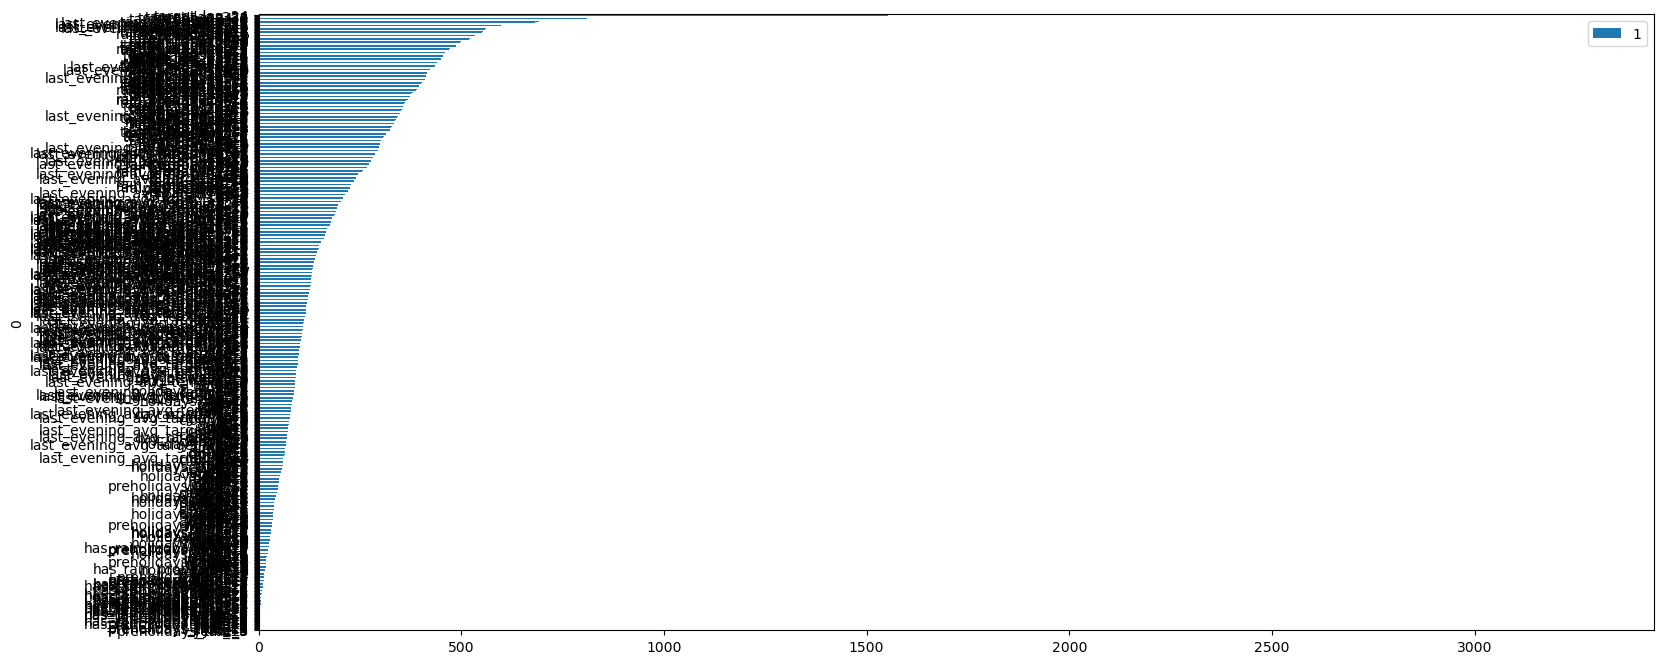

In [33]:
# График важности признаков

tmp_feature_cols = feat_lgbm_train.columns

feature_importances = pd.DataFrame([tmp_feature_cols, lgbm_model_all_train.feature_importances_]).T.sort_values(by = 1)
feature_importances.plot(kind='barh', x=0, y=1, figsize=(18, 8))

#### 4.2 XGBoost

In [34]:
features_all_train.columns

Index(['time', 'temp_pred', 'year', 'month', 'day_of_week', 'day',
       'holidays_true', 'preholidays_true', 'temp_last_day', 'target_lag_24',
       ...
       'last_evening_avg_target_19_23', 'last_evening_avg_temp_19_23',
       'last_evening_avg_target_22_23', 'last_evening_avg_temp_22_23',
       'target_1', 'temp_1', 'target_5', 'temp_5', 'target_9', 'temp_9'],
      dtype='object', length=798)

In [35]:
drop_list = ['preholidays_true',
            'has_rain_probability', 
            #'holidays', 'preholidays',
             'W', 'E'
            ]
feat_xgb_train = features_all_train.drop(columns=drop_list)
feat_xgb_test = features_open_test.drop(columns=drop_list)
feat_xgb_train.columns, feat_xgb_test.columns

(Index(['time', 'temp_pred', 'year', 'month', 'day_of_week', 'day',
        'holidays_true', 'temp_last_day', 'target_lag_24', 'target_lag_72',
        ...
        'last_evening_avg_target_19_23', 'last_evening_avg_temp_19_23',
        'last_evening_avg_target_22_23', 'last_evening_avg_temp_22_23',
        'target_1', 'temp_1', 'target_5', 'temp_5', 'target_9', 'temp_9'],
       dtype='object', length=794),
 Index(['time', 'temp_pred', 'year', 'month', 'day_of_week', 'day',
        'holidays_true', 'temp_last_day', 'target_lag_24', 'target_lag_72',
        ...
        'last_evening_avg_target_19_23', 'last_evening_avg_temp_19_23',
        'last_evening_avg_target_22_23', 'last_evening_avg_temp_22_23',
        'target_1', 'temp_1', 'target_5', 'temp_5', 'target_9', 'temp_9'],
       dtype='object', length=794))

In [36]:
xgb_model = XGBRegressor(
    max_depth=7,
    n_estimators=1190,
    learning_rate=0.009,
    tree_method='exact',
    objective='reg:squarederror',
    eval_metric='rmse',
    gamma=2,
    colsample_bytree=1,
    random_state=random_state

)


In [37]:
# Проверка метрики лучшей модели на тестовом датасете
# Здесь обучаем на всем тренировочном датасете


xgb_model_all_train = xgb_model.fit(feat_xgb_train, target_all_train)

xgb_predict_test = xgb_model_all_train.predict(feat_xgb_test)
xgb_predict_train = xgb_model_all_train.predict(feat_xgb_train)

mae_train, mape_train, r2_train = metrics_hour(target_all_train, xgb_predict_train )
mae_open_test, mape_open_test, r2_open_test = metrics_hour(target_open_test, xgb_predict_test )

results = pd.concat([results,
pd.DataFrame([[f'тренировочная XGB {FEATURES}', mae_train, mape_train, r2_train], [f'тестовая XGB {FEATURES}', mae_open_test, mape_open_test, r2_open_test]], 
             columns=('Выборка', 'MAE', 'MAPE', 'R2'))
 ])


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_

results.to_csv(f'results_LGBM_XGBoost_{FEATURES}_no_h')

In [38]:

l_predict_test = lgbm_model_all_train.predict(feat_lgbm_test)

xgb_predict_test = xgb_model_all_train.predict(feat_xgb_test)

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


In [39]:
results

,Выборка,MAE,MAPE,R2
0,тренировочная LGBM _Aug_20,3.172886,0.006653,0.996846
1,тестовая LGBM _Aug_20,6.164612,0.014443,0.985845
0,тренировочная XGB _Aug_20,3.847835,0.008095,0.997477
1,тестовая XGB _Aug_20,6.164715,0.014468,0.985017


### 5. Ensemble

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor

import optuna
from optuna.samplers import TPESampler

In [41]:
results_ensemble = pd.DataFrame(columns=('Выборка', 'MAE', 'MAPE', 'R2'))

### Simple Ensemble

In [42]:
predict_simple_ensemble_train = (xgb_predict_train + l_predict_train)/2
predict_simple_ensemble_test = (xgb_predict_test + l_predict_test)/2



In [43]:
mae_train, mape_train, r2_train = metrics_hour(target_all_train, predict_simple_ensemble_train)
mae_open_test, mape_open_test, r2_open_test = metrics_hour(target_open_test, predict_simple_ensemble_test)

results_ensemble = pd.concat([results_ensemble,
pd.DataFrame([[f'тренировочная simple_ensemble  {FEATURES}', mae_train, mape_train, r2_train], [f'тестовая simple_ensemble {FEATURES}', mae_open_test, mape_open_test, r2_open_test]], 
             columns=('Выборка', 'MAE', 'MAPE', 'R2'))
 ])

/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_

In [44]:
display(results_ensemble)
results

,Выборка,MAE,MAPE,R2
0,тренировочная simple_ensemble _Aug_20,3.396659,0.007129,0.997503
1,тестовая simple_ensemble _Aug_20,5.996702,0.014047,0.986154


,Выборка,MAE,MAPE,R2
0,тренировочная LGBM _Aug_20,3.172886,0.006653,0.996846
1,тестовая LGBM _Aug_20,6.164612,0.014443,0.985845
0,тренировочная XGB _Aug_20,3.847835,0.008095,0.997477
1,тестовая XGB _Aug_20,6.164715,0.014468,0.985017


In [45]:
mae_day(target_open_test, predict_simple_ensemble_test)

/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

97.87553032901711

In [46]:
import os

# определите путь к папке, которую вы хотите создать
folder_path = "models"

# проверьте, существует ли уже папка
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

lgbm_model_all_train.booster_.save_model('models/lgb_model.txt')
xgb_model.save_model('models/xgb_model.json')

In [ ]:
results.to_csv(f'models/results_LGBM_XGBoost_simple_ensemble_{FEATURES}')